## Make everything in Qiskit

In [7]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from qiskit.tools.visualization import plot_histogram
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.algorithms import MinimumEigenOptimizer

Problem name: Max-cut

Maximize
  -2*x_0*x_3 - 2*x_0*x_4 - 2*x_0*x_5 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_1*x_5
  - 2*x_2*x_4 - 2*x_2*x_5 - 2*x_3*x_4 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



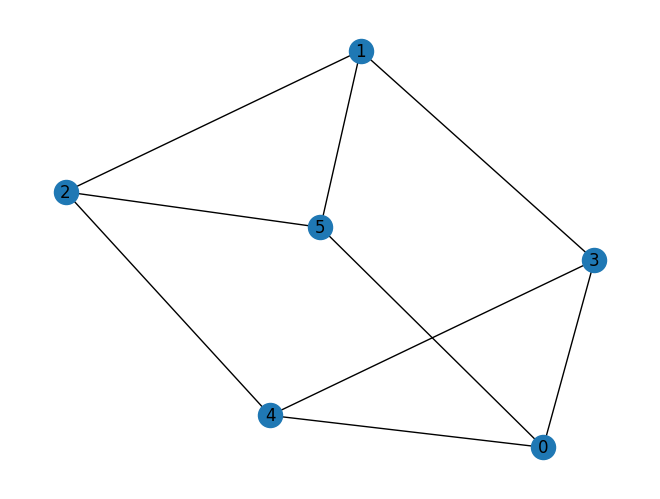

In [8]:
import networkx as nx

from qiskit_optimization.applications import Maxcut

seed = 12
num_nodes = 6



G = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(G, with_labels=True, pos=nx.spring_layout(G, seed=seed))

maxcut = Maxcut(G)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

In [9]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [10]:
# Initialize the weight matrix
w = np.zeros((num_nodes, num_nodes))

# Iterate over the edges of the graph and assign weights to the weight matrix
for edge in G.edges():
    node1, node2 = edge
    w[node1][node2] = 1
    w[node2][node1] = 1  # Assuming undirected graph

# Print the weight matrix
#print("Weight Matrix:")
#print(w)

In [11]:
import time
pos = nx.spring_layout(G)


Best solution = [1, 1, 1, 0, 0, 0] cost = 7.0
elapsed time = 0.021016836166381836 sec


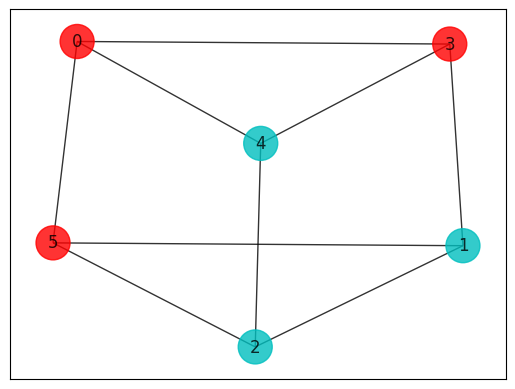

In [12]:
tic = time.time()
best_cost_brute = 0
for b in range(2**num_nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(num_nodes)))]
    cost = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    #print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(num_nodes)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")

In [13]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_3 - 2*x_0*x_4 - 2*x_0*x_5 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_1*x_5
  - 2*x_2*x_4 - 2*x_2*x_5 - 2*x_3*x_4 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



In [14]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -4.5
Ising Hamiltonian:
SparsePauliOp(['IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'ZIIIZI', 'IZIZII', 'ZIIZII', 'IZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


In [15]:
# Problem to Hamiltonian operator
hamiltonian = qubitOp

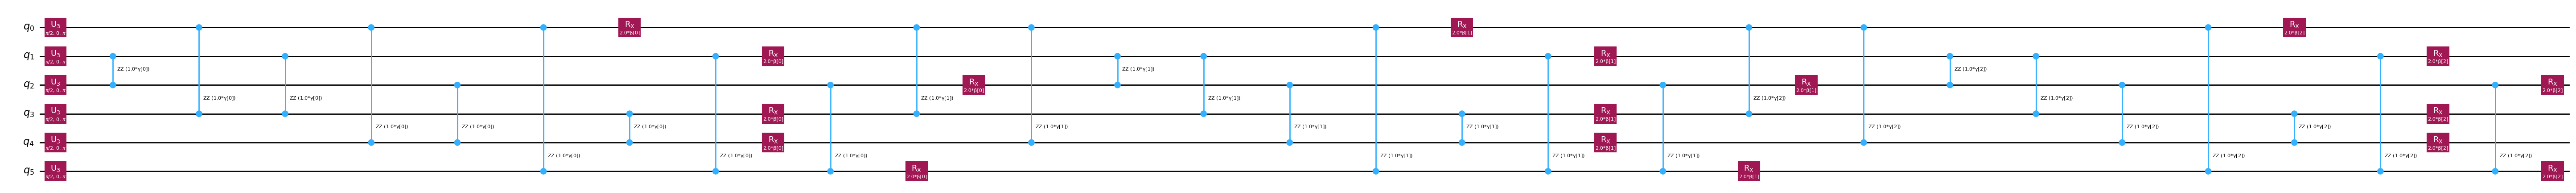

In [17]:
# QAOA ansatz circuit
from qiskit.circuit.library import QAOAAnsatz
ansatz = QAOAAnsatz(hamiltonian, reps=3)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [18]:
ansatz.num_qubits

6

In [19]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

Selecting the Backend

In [20]:
from pytket.circuit import Circuit, fresh_symbol, OpType
from pytket.circuit.display import render_circuit_jupyter

from pytket.extensions.quantinuum import QuantinuumBackend
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_quantinuum import Quantinuum



In [22]:
# Quantinuum.save_account(user_name="first.last@company.com")
Quantinuum.save_account(user_name="monitsharma@smu.edu.sg")
Quantinuum.load_account()

Your id token is expired. Refreshing...


In [39]:
device = 'H1-1E'
backend = Quantinuum.get_backend(device)

In [40]:
status = backend.status()

print(device, "status :", status.status_msg)

H1-1E status : online


In [41]:
from qiskit_aer import AerSimulator
simulator = AerSimulator() 

In [42]:
from qiskit.primitives import BackendSampler, BackendEstimator

estimator = BackendEstimator(backend=backend,options={"shots": 100})
sampler = BackendSampler(backend=simulator)

In [43]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
print(x0)

[5.63793815 4.65496466 3.82458244 2.06822269 1.18028916 3.32962042]


In [44]:
from scipy.optimize import minimize
tic = time.time()
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="POWELL", options={"maxiter": 100})
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4.5
       x: [ 2.172e+00  4.237e-01  1.914e+00  7.120e-01  1.007e+00
            4.467e+00]
     nit: 1
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 19

In [ ]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()

In [ ]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]
# Close the session since we are now done with it


In [ ]:
my_dict = dict(sorted(samp_dist.binary_probabilities().items(),key=lambda item: item[1], reverse=True))

In [ ]:
#my_dict = samp_dist.binary_probabilities()
print(my_dict)

{'111111': 0.072265625, '000000': 0.046875, '000001': 0.0380859375, '010000': 0.0380859375, '100000': 0.0361328125, '110111': 0.03515625, '111110': 0.03515625, '111011': 0.03515625, '101111': 0.0341796875, '000100': 0.03125, '001000': 0.0302734375, '011111': 0.0302734375, '101101': 0.029296875, '110011': 0.02734375, '111101': 0.02734375, '001111': 0.0263671875, '110000': 0.025390625, '000010': 0.0234375, '010010': 0.0234375, '000101': 0.0224609375, '000011': 0.021484375, '101000': 0.0166015625, '001100': 0.015625, '101110': 0.015625, '111100': 0.015625, '111010': 0.0146484375, '011011': 0.013671875, '001010': 0.0126953125, '010111': 0.0126953125, '100110': 0.0126953125, '011001': 0.0126953125, '010100': 0.01171875, '100001': 0.0107421875, '110101': 0.0107421875, '100100': 0.009765625, '011000': 0.009765625, '011110': 0.009765625, '101100': 0.0087890625, '111000': 0.0087890625, '001001': 0.0078125, '100010': 0.0078125, '111001': 0.0078125, '000110': 0.0068359375, '010001': 0.0068359375,